In [13]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

from scipy.stats import mannwhitneyu, binom
rstest_twosided = lambda x, y : mannwhitneyu(x, y, alternative='two-sided')

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.utils.plotting import imshow, random_colors
from mesostat.metric.sequence import avg_bivariate_binary_orderability_from_temporal_mean, bivariate_orderability_from_temporal_mean
from mesostat.stat.machinelearning import binary_classifier
from mesostat.stat.connectomics import offdiag_1D
from mesostat.stat.permtests import perm_test, difference_test
from mesostat.stat.resampling import sample


from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
from src.lib.metric_wrapper import metric_by_selector
from src.lib.extra_metrics import num_non_zero_std, num_sample
from src.lib.stat_lib import test_quantity
from src.lib.clustering import cluster_dist_matrix
from src.lib.significant_cells_lib import SignificantCells

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/chernysheva-tmaze-analysis-2020
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
# params['root_path_dff'] = '/home/alyosha/Desktop/maria/dff/'
# params['root_path_deconv'] = '/home/alyosha/Desktop/maria/deconv/'
# params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
# params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [3]:
dataDB = BehaviouralNeuronalDatabase(params)

In [4]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [5]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


In [6]:
signCells = SignificantCells('significant_cells_maintenance.h5')
signCellsMouseDict = signCells.get_cells_by_mouse()
signCellsMouseDict

{'m060': array([16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 61, 62, 63, 65,
        66, 67, 69, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85,
        87]),
 'm067': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 47, 48]),
 'm065': array([13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 47, 48, 49, 51, 69,
        71, 72, 73, 74, 77, 78, 79, 80, 82]),
 'm068': array([ 9, 10, 12, 13, 14, 15, 16, 23, 24, 25, 26]),
 'm061': array([ 7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 24, 28, 29, 30, 31, 32,
        33, 35, 36, 37, 38, 39, 40, 41, 44]),
 'm066': array([ 6,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
        41, 42, 44, 45, 46])}

# Q1: Do temporal features predict modality

Predictors:
* mean by cell, variance of mean by cell
* temporal_order by cell -> (cell-wise test, proxy via tsne)
* legendre basis by cell -> (cell-wise base wise test, proxy via tsne)
* var(temp_order) by trial by cell -> (cell-wise test, proxy via tsne)
* var(legendre_basis) by trial by cell -> (cell-wise test, proxy via tsne)
* binary_orderability
    - permutation test on directly on ABO
    - (maybe) significance matrix for each link, test counting (prob. via permutation test)
* sequencability -> proxy via tsne (count if cell does approx 1 spike)

Variations:
* Time : [Stretched, Min-cropped]
* Cells : [All, Significantly active]

## 1.1 Temporal Mean by cell

In [7]:
def count_significant_cells(dataDB, queryDict, selector, condition, metricName, nResample=1000, pval=0.01, proxyFunc=None):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    settings = {"dropShortTrialsTHR" : 5}
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
            means += [metric_by_selector(dataDB, queryDictCond, metricName, "pr", selector, settings)]
            
        nCells = dataDB.get_nchannel(mousename, queryDict['datatype'])
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(means[0], means[1], pval, nResample=nResample, proxyFunc=proxyFunc)
            
        mouseResults += [[mousename, nCellSignificant, nCells, np.round(negLogPValPop, 1)]]
        
    display(pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "-log10(pval)"]))

In [13]:
for iInterv in range(5, 8):
    print("Interval", iInterv)
    queryDict = {"datatype" : "raw", "performance" : "Correct"}
#     queryDict = {"datatype" : "deconv", "direction" : "R"}
    count_significant_cells(dataDB, queryDict, {"interval" : iInterv}, "direction", "ord_mean")

Interval 5


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,25,88,28.5
1,m061,0,46,0.0
2,m065,6,83,3.7
3,m066,4,47,2.9
4,m067,4,49,2.8
5,m068,0,28,-0.0


Interval 6


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,3,88,1.2
1,m061,0,46,0.0
2,m065,8,83,5.7
3,m066,1,47,0.4
4,m067,0,49,0.0
5,m068,1,28,0.6


Interval 7


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,2,88,0.7
1,m061,0,46,0.0
2,m065,5,83,2.8
3,m066,0,47,-0.0
4,m067,0,49,0.0
5,m068,1,28,0.6


## 1.2 Variance of Temporal Mean by cell

In [48]:
diff_func = lambda x,y: np.std(x) - np.std(y)
# queryDict = {"datatype" : "deconv", "performance" : "Correct"}
queryDict = {"datatype" : "raw", "direction" : "R"}

for iInterv in range(5, 8):
    print("Interval", iInterv)
    count_significant_cells(dataDB, queryDict, {"interval" : iInterv}, "performance", "ord_mean", proxyFunc=diff_func, nResample=1000)

Interval 5
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,2,88,0.7
1,m061,0,46,0.0
2,m065,2,83,0.7
3,m066,3,47,1.9
4,m067,1,49,0.4
5,m068,1,28,0.6


Interval 6
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


KeyboardInterrupt: 

## 1.3 Legendre Basis by cell

In [50]:
def count_significant_cells_legendre(dataDB, queryDict, selector, condition, basisIdx, nResample=1000, pval=0.01, proxyFunc=None):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    settings = {"dropShortTrialsTHR" : 5}
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
            means += [metric_by_selector(dataDB, queryDictCond, 'temporal_basis', "pr", selector, settings)[:,:,basisIdx]]
            
        nCells = dataDB.get_nchannel(mousename, queryDict['datatype'])
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(means[0], means[1], pval, nResample=nResample, proxyFunc=proxyFunc)
            
        mouseResults += [[mousename, nCellSignificant, nCells, np.round(negLogPValPop, 1)]]
        
    display(pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "-log10(pval)"]))

In [53]:
queryDict = {"datatype" : "raw", "performance" : "Correct"}
# queryDict = {"datatype" : "raw", "direction" : "R"}

for iInterv in range(5, 8):
    print("Interval", iInterv)
    count_significant_cells_legendre(dataDB, queryDict, {"interval" : iInterv}, "direction", 1)

Interval 5


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,23,88,25.3
1,m061,3,46,2.0
2,m065,10,83,7.9
3,m066,4,47,2.9
4,m067,4,49,2.8
5,m068,1,28,0.6


Interval 6


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,3,88,1.2
1,m061,0,46,0.0
2,m065,6,83,3.7
3,m066,1,47,0.4
4,m067,1,49,0.4
5,m068,1,28,0.6


Interval 7


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,1,88,0.2
1,m061,2,46,1.1
2,m065,5,83,2.8
3,m066,0,47,-0.0
4,m067,0,49,0.0
5,m068,0,28,-0.0


In [63]:
# queryDict = {"datatype" : "deconv", "performance" : "Correct"}
queryDict = {"datatype" : "deconv", "direction" : "R"}

for iInterv in range(5, 8):
    print("Interval", iInterv)
    count_significant_cells_legendre(dataDB, queryDict, {"interval" : iInterv}, "performance", 2, proxyFunc=np.std)

Interval 5
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,0,88,0.0
1,m061,1,46,0.4
2,m065,0,83,0.0
3,m066,0,47,-0.0
4,m067,0,49,0.0
5,m068,1,28,0.6


Interval 6
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,3,88,1.2
1,m061,2,46,1.1
2,m065,2,83,0.7
3,m066,1,47,0.4
4,m067,1,49,0.4
5,m068,0,28,-0.0


Interval 7
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping


,mouse,nCellSignificant,nCellTot,-log10(pval)
0,m060,3,88,1.2
1,m061,1,46,0.4
2,m065,4,83,2.0
3,m066,3,47,1.9
4,m067,0,49,0.0
5,m068,1,28,0.6


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,5,440,0.3
1,m061,1,230,0.0
2,m065,6,415,0.6
3,m066,0,235,-0.0
4,m067,4,245,0.6
5,m068,4,140,1.3


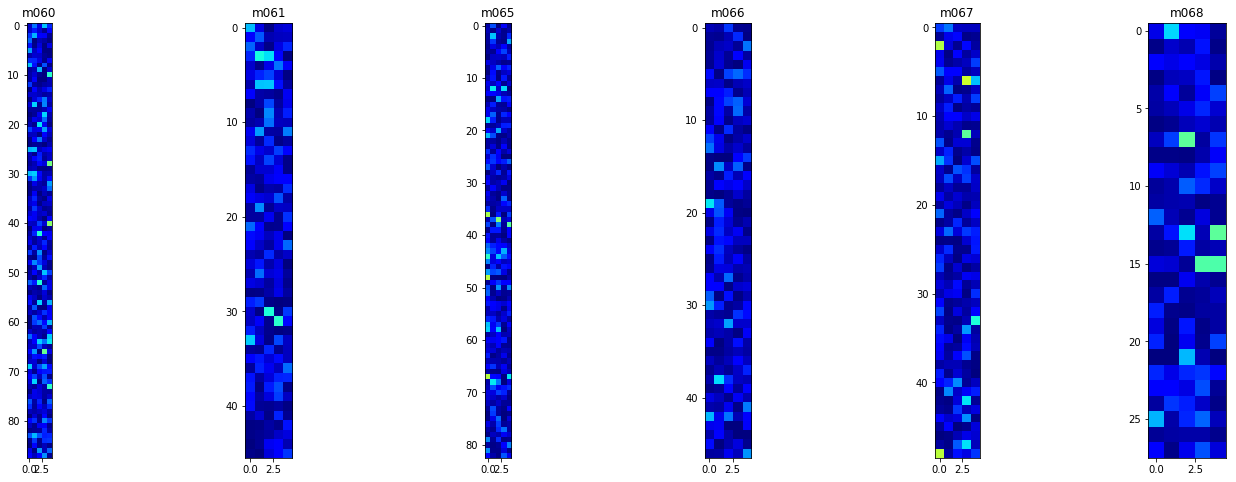

In [27]:
def test_mean_legendre(dataDB, queryDict, selector, condition, nTest=1000, pval=0.01):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    settings = {"dropShortTrialsTHR" : 5}
    
    fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(4*len(dataDB.mice), 8))
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
            means += [metric_by_selector(dataDB, queryDictCond, "temporal_basis", "rp", selector, settings)]
            
        nTrialsA, nCells, nBasis = means[0].shape
        nTrialsB, nCells, nBasis = means[1].shape
        
        meansA = means[0].reshape((nTrialsA, nCells*nBasis)).T
        meansB = means[1].reshape((nTrialsB, nCells*nBasis)).T
        
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(meansA, meansB, pval)
        
        pValByCellReshaped = np.array(pValByCell).reshape((nCells, nBasis))
        negLogPValByCell = -np.log10(pValByCellReshaped)
        
        ax[iMouse].imshow(negLogPValByCell, vmin=0, vmax=5, cmap="jet")
        ax[iMouse].set_title(mousename)
            
        mouseResults += [[mousename, nCellSignificant, nCells*nBasis, negLogPValPop]]
        
    display(pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "pvalPopulation"]))
    plt.show()
    
queryDict = {"datatype" : "deconv", "performance" : "Correct"}
# queryDict = {"datatype" : "deconv", "direction" : "R"}
test_mean_legendre(dataDB, queryDict, {"interval" : 7}, "direction")

# 2 Testing orderability

1. For each trial and channel, compute temporal means
2. For a set of trials, compute average binary orderability from temporal means
3. Do permutation test on modality trials

In [14]:
diff_func = lambda x, y: avg_bivariate_binary_orderability_from_temporal_mean(x) - avg_bivariate_binary_orderability_from_temporal_mean(y)

def test_orderability(dataDB, queryDict, selector, condition, nResample=1000, pval=0.01, proxyFunc=None, useSignificant=False):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    settings = {"dropShortTrialsTHR" : 5}
    
    if useSignificant:
        channelFilter = signCellsMouseDict
    else:
        channelFilter = None
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
            means += [metric_by_selector(dataDB, queryDictCond, "ord_mean", "rp", selector, settings, channelFilter=channelFilter)]
            
        pLess, pMore = difference_test(diff_func, means[0], means[1], nSample=1000, sampleFunction="permutation")

        print("For mouse", mousename, "orderability test is", pLess, pMore)
    
# queryDict = {"datatype" : "deconv", "performance" : "Correct"}
queryDict = {"datatype" : "deconv"} #, "direction" : "L"
for interval in range(5,8):
    for useSignificant in [True, False]:
        print("Interval", interval, useSignificant)
        test_orderability(dataDB, queryDict, {"interval" : interval}, "direction", useSignificant=useSignificant)

Interval 5 True
For mouse m060 orderability test is 0.001 1.0
For mouse m061 orderability test is 0.322 0.679
For mouse m065 orderability test is 0.691 0.309
For mouse m066 orderability test is 0.523 0.477
For mouse m067 orderability test is 0.316 0.684
For mouse m068 orderability test is 0.361 0.639
Interval 5 False
For mouse m060 orderability test is 0.001 1.0
For mouse m061 orderability test is 0.287 0.713
For mouse m065 orderability test is 0.321 0.679
For mouse m066 orderability test is 0.398 0.602
For mouse m067 orderability test is 0.641 0.359
For mouse m068 orderability test is 0.488 0.512
Interval 6 True
For mouse m060 orderability test is 0.05 0.95
For mouse m061 orderability test is 0.272 0.728
For mouse m065 orderability test is 0.094 0.906
For mouse m066 orderability test is 0.912 0.088
For mouse m067 orderability test is 0.532 0.468
For mouse m068 orderability test is 0.911 0.089
Interval 6 False
For mouse m060 orderability test is 0.135 0.865
For mouse m061 orderability 

# Q2: Presence of relative temporal structure in the firing pattern

Metrics:
* Temporal Mean
* Bivariate Orderability (undirected)
* Bivariate Orderability (directed)

Hypotheses:
* Exist clusters of neurons that are orderable wrt other neurons and not orderable wrt each other
* Exist neurons that prefer to spike earlier vs later, which makes them more orderable

TODO:
* Cluster meanings
    - impl directional BO, sort clusters by direction
* Directed interpretation
    - Calculate directed BO
    - Calculate average BO per channel (directed)
    - Scatter average BO with temporal mean of the channel
    - Try avg directed orderability as single channel predictor of modality
* Shift invariance - are there cells where difference in average temporal mean is not a predictor of orderability?
    - Calc average difference matrix, scatter it vs orderability
* Significance of ABO:
    - Permutation-test ABO by interval, including maintenance and retrieval
    - Filter cells, see if filtered have higher orderability

In [16]:
def mat_order_by_idx(M, idx):
    return np.copy(M[idx][:, idx])

def pairwise_subtract(data1D):
    dataExtrudeX = np.outer(np.ones(len(data1D)), data1D)
    return dataExtrudeX - dataExtrudeX.T

def get_mat_triu_elems(m):
    return m[np.triu_indices(m.shape[0])]

In [35]:
def plots_orderability(dataDB, queryDict, selector, nResample=100):    
    nMice = len(dataDB.mice)
    
    figureProp = {
        "ord"            : (4, 4, "Orderability matrices"),
        "ordSort"        : (4, 4, "Orderability matrices, sorted by max orderability"),
        "ordSort1D"      : (4, 4, "Orderability averaged for each cell"),
        "ordCorr"        : (4, 4, "Absolute Correlation between sorted orderability rows"),
        "ordCorrClust"   : (4, 4, "Absolute Correlation, sorted by clustering"),
        "ordClust"       : (4, 4, "Orderability matrices, clustered by highest correlation"),
        #"tempMeanHist"   : (4, 4, "Temporal mean histogram"),
        "avgResampledTemp": (10, 10, "Average resampled activity, colored by temporal mean"),
        "avgResampledClust": (10, 10, "Average resampled activity, colored by cluster"),
        "avgResampledClustAvg": (5, 5, "Average resampled activity, colored by cluster, cell-average")
    }
    
    figs = {}                    
    for key, (xScale, yScale, title) in figureProp.items():
        fig, ax = plt.subplots(ncols=nMice, figsize=(xScale*nMice, yScale))
        fig.suptitle(title)
        figs[key] = (fig, ax)
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Doing mouse", mousename)
        queryDictThis = {**queryDict, **{'mousename' : mousename}}

        ########################
        # Calculations
        ########################
        
        # Calculate orderability and temporal means
        dataBinOrd = metric_by_selector(dataDB, queryDictThis, "ord_binary", "", selector, {})
        dataTempMu = metric_by_selector(dataDB, queryDictThis, "ord_mean", "p", selector, {})
        
        # Find indices of sorted temporal order
        idxSortTempMu = np.argsort(dataTempMu)
        
        # Sort orderability matrix in descending order of average orderability per cell
        meanBinOrd1D = np.nanmean(dataBinOrd, axis=0)
        idxSortBinOrd = np.argsort(meanBinOrd1D)[::-1]
        dataBinOrdSorted = mat_order_by_idx(dataBinOrd, idxSortBinOrd)
        
        # Correlation matrix of cells
        dataBinOrdSortedZero = np.copy(dataBinOrdSorted)
        np.fill_diagonal(dataBinOrdSortedZero, 0)
        dataBinOrdSortedCorr = np.abs(np.corrcoef(dataBinOrdSortedZero))

        # Clustering of correlation matrix
        clustering = cluster_dist_matrix(dataBinOrdSortedCorr, 0.5, method='affinity')
        idxClustering = np.argsort(clustering)
        clusteringSorted = clustering[idxClustering]
        
        # Orderability and correlation sorted by clustering
        dataBinOrdSortedCorrClust = mat_order_by_idx(dataBinOrdSortedCorr, idxClustering)
        dataBinOrdClust = mat_order_by_idx(dataBinOrdSorted, idxClustering)
        
        # Resampled cell activities sorted by clustering
        cellResampledActivity = metric_by_selector(dataDB, queryDictThis, "resample_fixed", "p", selector, {"metricSettings" : {"nResamplePoint":nResample}})
        cellResampledActivitySortCluster = cellResampledActivity[idxClustering]
        cellResampledActivitySortTemporal = cellResampledActivity[idxSortTempMu]
        
        ########################
        # Plotting
        ########################
        getfigs = lambda figname: (figs[figname][0], figs[figname][1][iMouse])
        
        imshow(*getfigs("ord"), dataBinOrd, title=mousename, haveColorBar=True, limits=[0, 1])

        imshow(*getfigs("ordSort"), dataBinOrdSorted, title=mousename, haveColorBar=True, limits=[0, 1])
        
        figs["ordSort1D"][1][iMouse].plot(meanBinOrd1D[idxSortBinOrd])
        
        imshow(*getfigs("ordCorr"), dataBinOrdSortedCorr, title=mousename, haveColorBar=True, limits=[0, 1])
        
        imshow(*getfigs("ordCorrClust"), dataBinOrdSortedCorrClust, title=mousename, haveColorBar=True, limits=[0, 1])
        plots_lib.clustering_imshow_overplot_lines(figs["ordCorrClust"][1][iMouse], clustering)
        
        imshow(*getfigs("ordClust"), dataBinOrdClust, title=mousename, haveColorBar=True, limits=[0, 1])
        plots_lib.clustering_imshow_overplot_lines(figs["ordClust"][1][iMouse], clustering)
        
        imshow(*getfigs("avgResampledTemp"), cellResampledActivitySortTemporal, title=mousename, haveColorBar=True)
        
        imshow(*getfigs("avgResampledClust"), cellResampledActivitySortCluster, title=mousename, haveColorBar=True)
        plots_lib.clustering_imshow_overplot_lines(figs["avgResampledClust"][1][iMouse], clustering, haveV=False)
  
        xResample = np.arange(nResample)
        for cluster in set(clustering):
            thisClusterData = cellResampledActivity[np.array(clustering) == cluster]
            muTrace = np.mean(thisClusterData, axis=0)
            stdTrace = np.std(thisClusterData, axis=0)
            figs["avgResampledClustAvg"][1][iMouse].plot(xResample, muTrace, label=cluster)
            figs["avgResampledClustAvg"][1][iMouse].fill_between(xResample, muTrace-stdTrace, muTrace+stdTrace, alpha=0.3)
            
        figs["avgResampledClustAvg"][1][iMouse].legend()

#         nCluster = len(set(clustering))
#         colors = random_colors(nCluster)
#         for iCell, cellAct in enumerate(cellResampledActivity):
#             thisColor = colors[clusteringSorted[iCell]]
#             figs["avgResampledAct"][1][iMouse].plot(cellAct + iCell, color=thisColor)

    # Save all figures
    for key, (fig, ax) in figs.items():
        plt.figure(fig.number)
        plt.savefig(key + '.pdf')

Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068
CPU times: user 9min 24s, sys: 7min 52s, total: 17min 17s
Wall time: 2min 21s


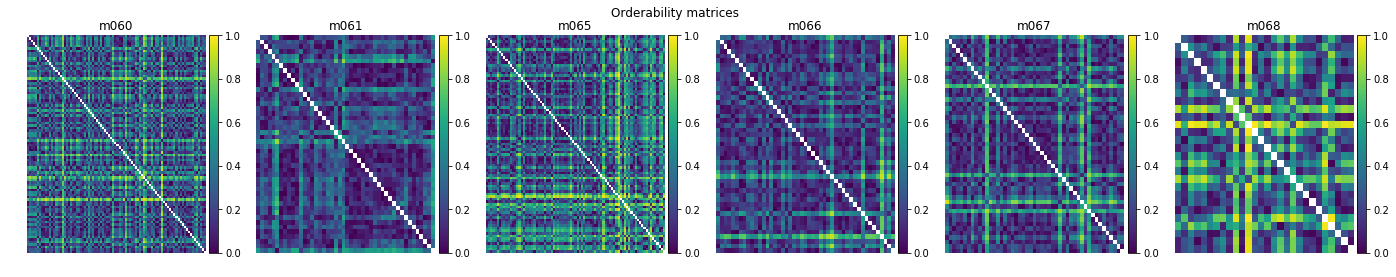

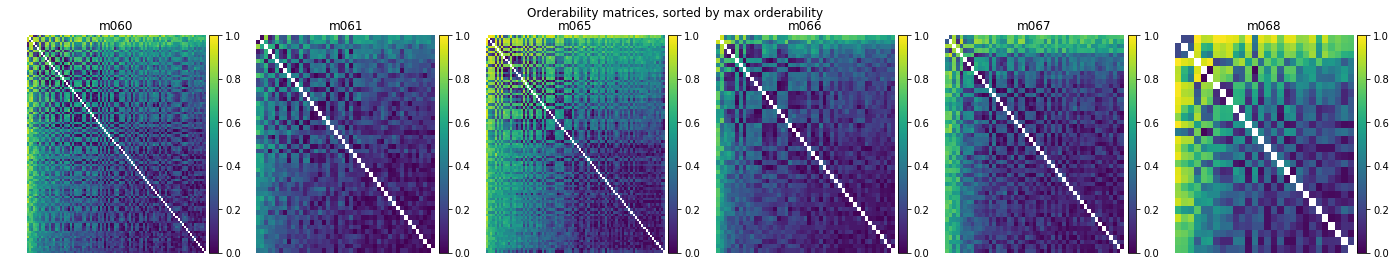

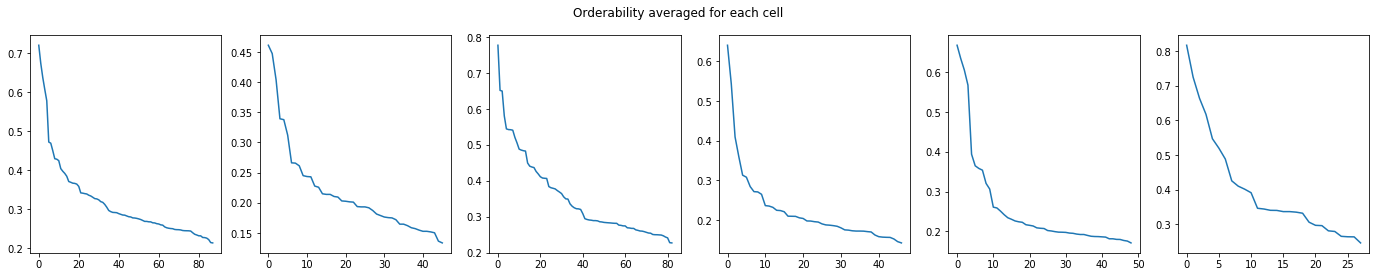

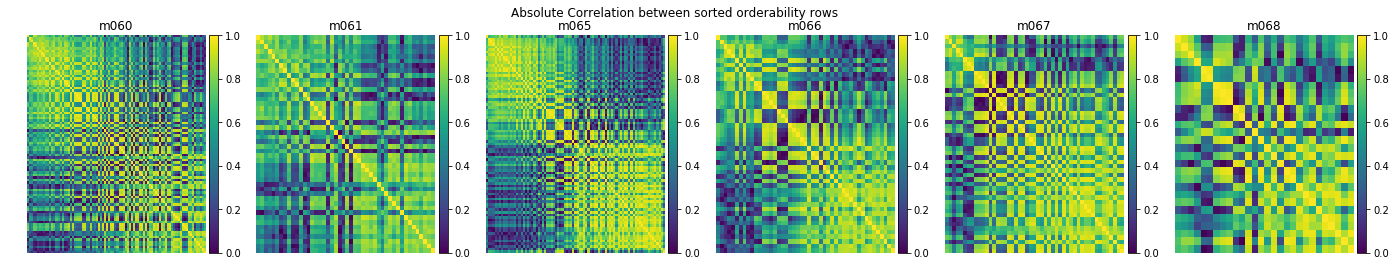

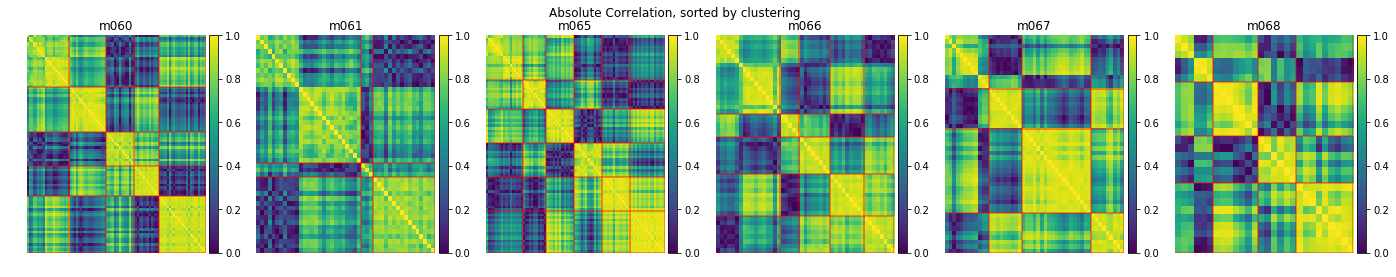

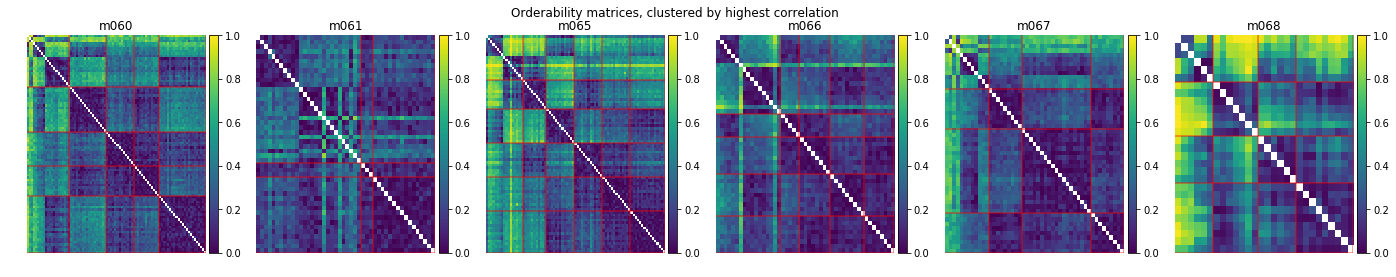

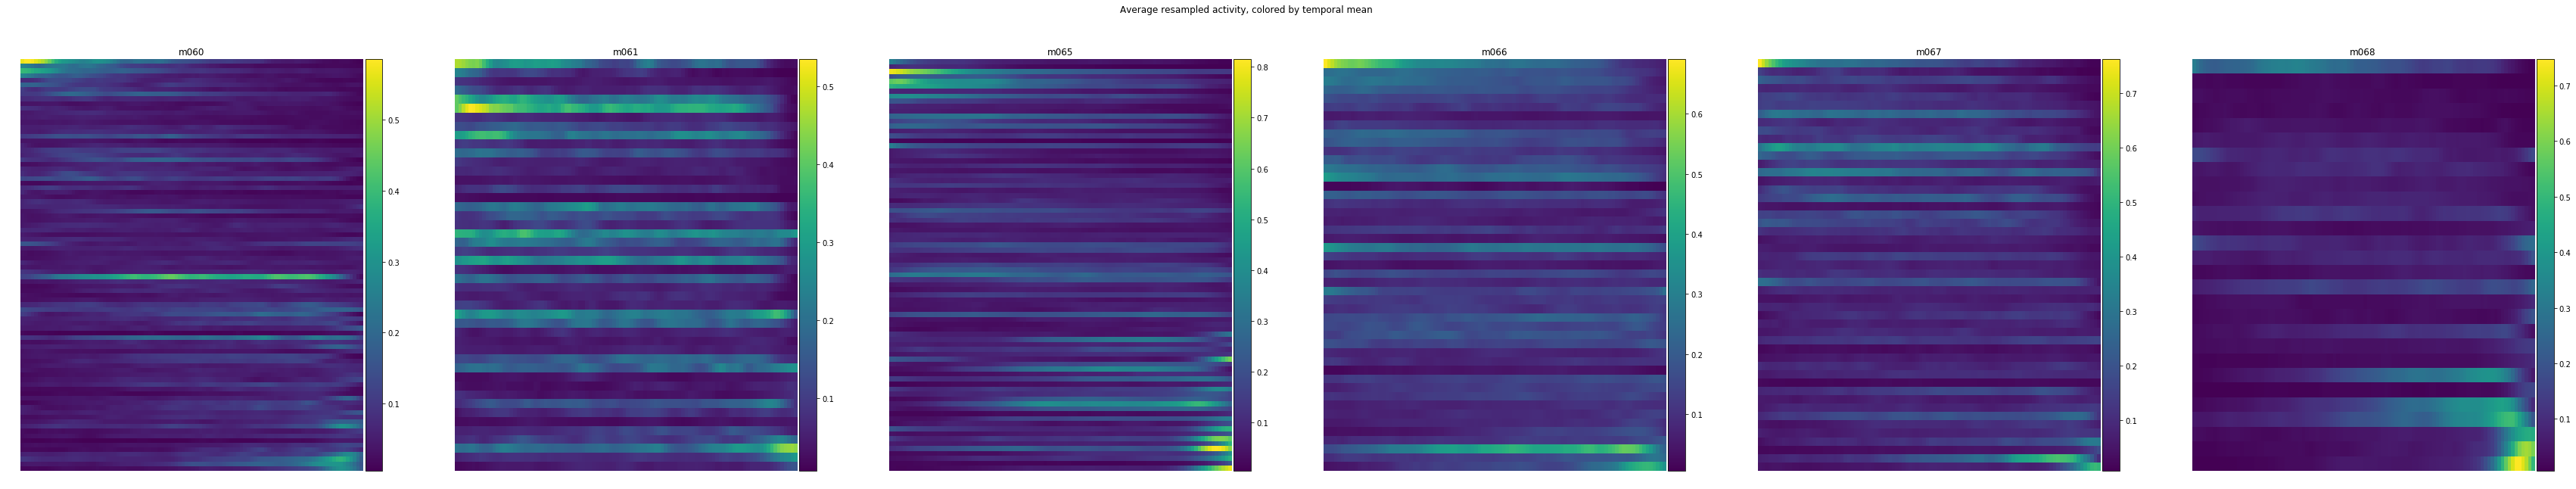

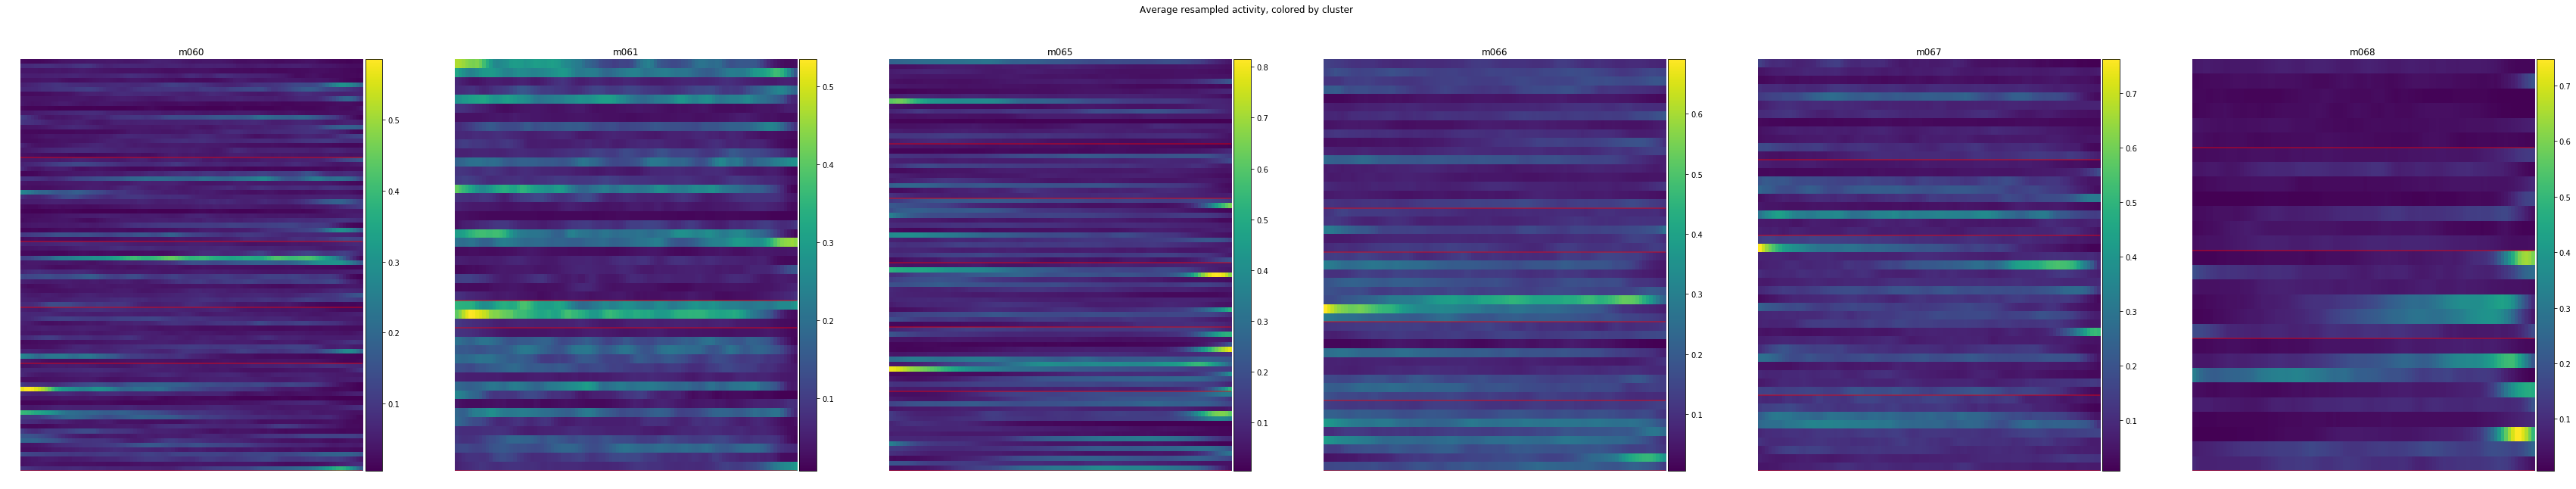

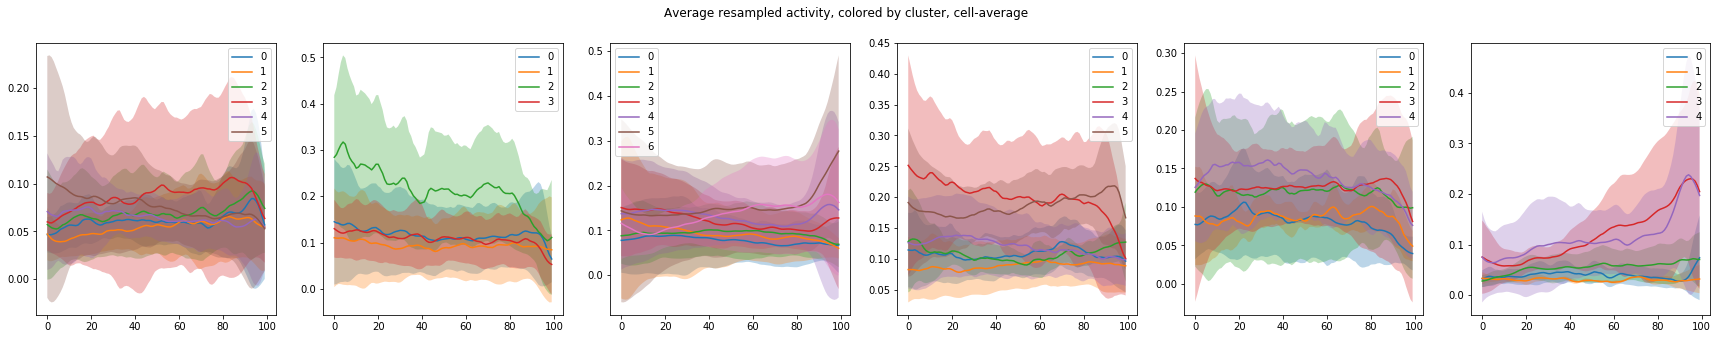

In [36]:
%%time
queryDict = {'datatype' : 'deconv'}
# plots_orderability(dataDB, queryDict, {"phase" : "Maintenance"}, nResample=200)
plots_orderability(dataDB, queryDict, {"interval" : 7}, nResample=100)

Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068


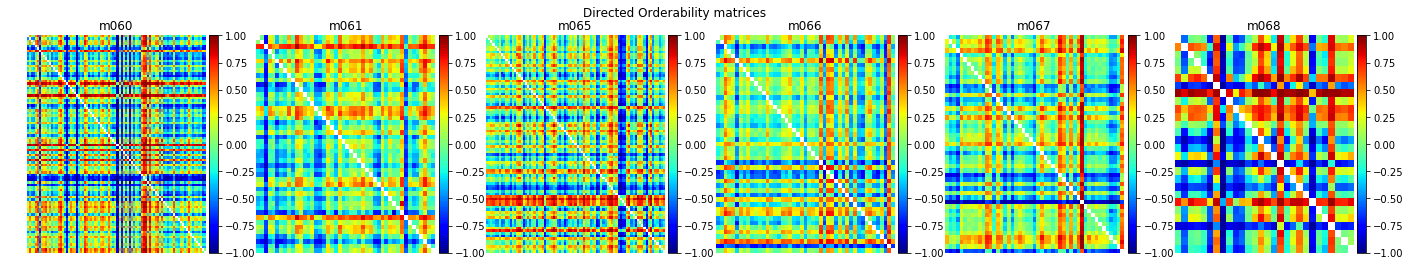

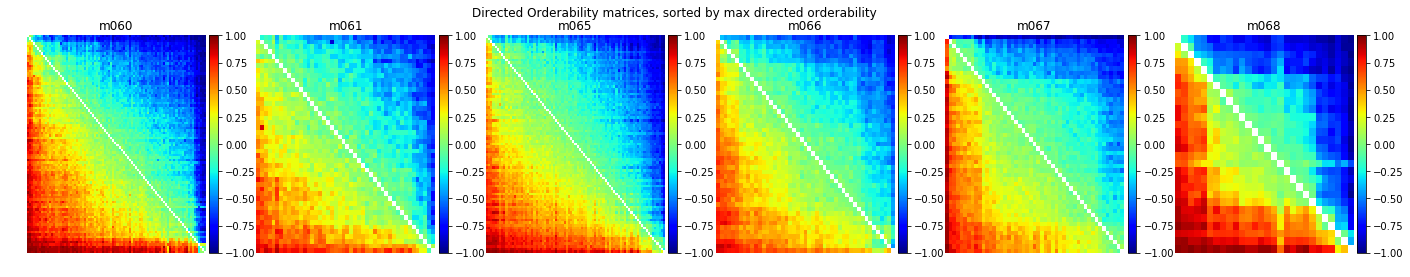

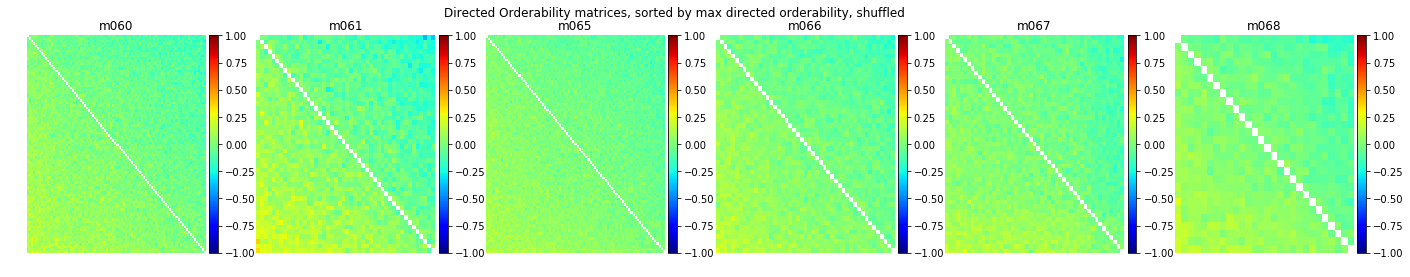

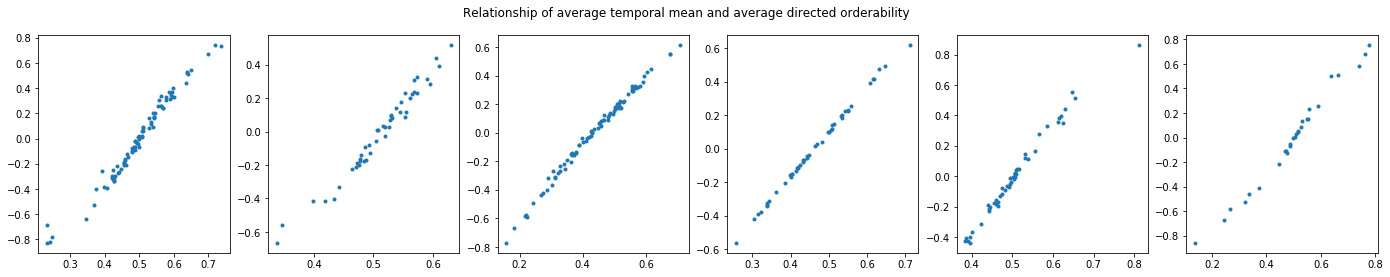

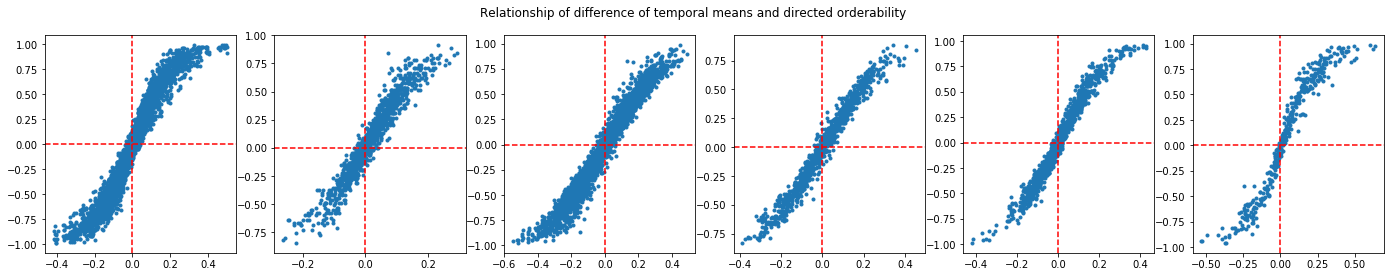

In [18]:
def plots_directed_orderability(dataDB, queryDict, selector):    
    nMice = len(dataDB.mice)
    
    figureProp = {
        "ord"            : (4, 4, "Directed Orderability matrices"),
        "ordSort"        : (4, 4, "Directed Orderability matrices, sorted by max directed orderability"),
        "ordSortShuffle" : (4, 4, "Directed Orderability matrices, sorted by max directed orderability, shuffled"),
        "ordMuScatter"   : (4, 4, "Relationship of average temporal mean and average directed orderability"),
        "ordShiftInv"    : (4, 4, "Relationship of difference of temporal means and directed orderability"),
    }
    
    figs = {}                    
    for key, (xScale, yScale, title) in figureProp.items():
        fig, ax = plt.subplots(ncols=nMice, figsize=(xScale*nMice, yScale))
        fig.suptitle(title)
        figs[key] = (fig, ax)
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Doing mouse", mousename)
        queryDictThis = {**queryDict, **{'mousename' : mousename}}

        ########################
        # Calculations
        ########################
        
        # Calculate orderability and temporal means
        settings = {"metricSettings" : {"directed" : True}, "dropShortTrialsTHR" : 4}
        dataBinOrd = metric_by_selector(dataDB, queryDictThis, "ord_binary", "", selector, settings)
        dataTempMu = metric_by_selector(dataDB, queryDictThis, "ord_mean", "rp", selector, settings)
        
        # Sort orderability matrix in descending order of average orderability per cell
        meanBinOrd1D = np.nanmean(dataBinOrd, axis=0)
        idxSortBinOrd = np.argsort(meanBinOrd1D)[::-1]
        dataBinOrdSorted = mat_order_by_idx(dataBinOrd, idxSortBinOrd)
        
        # Calculate permuted orderability
        dataTempMuShuffle = sample(dataTempMu, 'permutation', permAxis=1, iterAxis=0)
        dataBinOrdShuffle = bivariate_orderability_from_temporal_mean(dataTempMuShuffle, {"directed" : True})
        meanBinOrd1DShuffle = np.nanmean(dataBinOrdShuffle, axis=0)
        idxSortBinOrdShuffle = np.argsort(meanBinOrd1DShuffle)[::-1]
        dataBinOrdSortedShuffle = mat_order_by_idx(dataBinOrdShuffle, idxSortBinOrdShuffle)
        
        # Calculate difference matrix of temporal means
        dataTempMuAvg = np.mean(dataTempMu, axis=0)
        diffTempMu = pairwise_subtract(dataTempMuAvg)
        diffTempMu1D = get_mat_triu_elems(diffTempMu)
        dataBinOrd1D = get_mat_triu_elems(dataBinOrd)
                
        ########################
        # Plotting
        ########################
        getfigs = lambda figname: (figs[figname][0], figs[figname][1][iMouse])
        
        imshow(*getfigs("ord"), dataBinOrd, title=mousename, haveColorBar=True, limits=[-1, 1], cmap='jet')

        imshow(*getfigs("ordSort"), dataBinOrdSorted, title=mousename, haveColorBar=True, limits=[-1, 1], cmap='jet')
        
        imshow(*getfigs("ordSortShuffle"), dataBinOrdSortedShuffle, title=mousename, haveColorBar=True, limits=[-1, 1], cmap='jet')
        
        getfigs("ordMuScatter")[1].plot(dataTempMuAvg, meanBinOrd1D, '.')
        
        getfigs("ordShiftInv")[1].plot(diffTempMu1D, dataBinOrd1D, '.')
        getfigs("ordShiftInv")[1].axhline(y=0, linestyle='--', color='r')
        getfigs("ordShiftInv")[1].axvline(x=0, linestyle='--', color='r')
        
    # Save all figures
    for key, (fig, ax) in figs.items():
        plt.figure(fig.number)
        plt.savefig("directed_"+ key + '.pdf')
        

queryDict = {'datatype' : 'raw'}
plots_directed_orderability(dataDB, queryDict, {"phase" : "Maintenance"})
# plots_directed_orderability(dataDB, queryDict, {"interval" : 5})

Doing mouse m060
Doing mouse m061
Doing mouse m065
Doing mouse m066
Doing mouse m067
Doing mouse m068


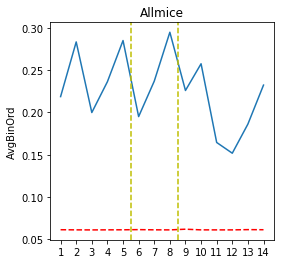

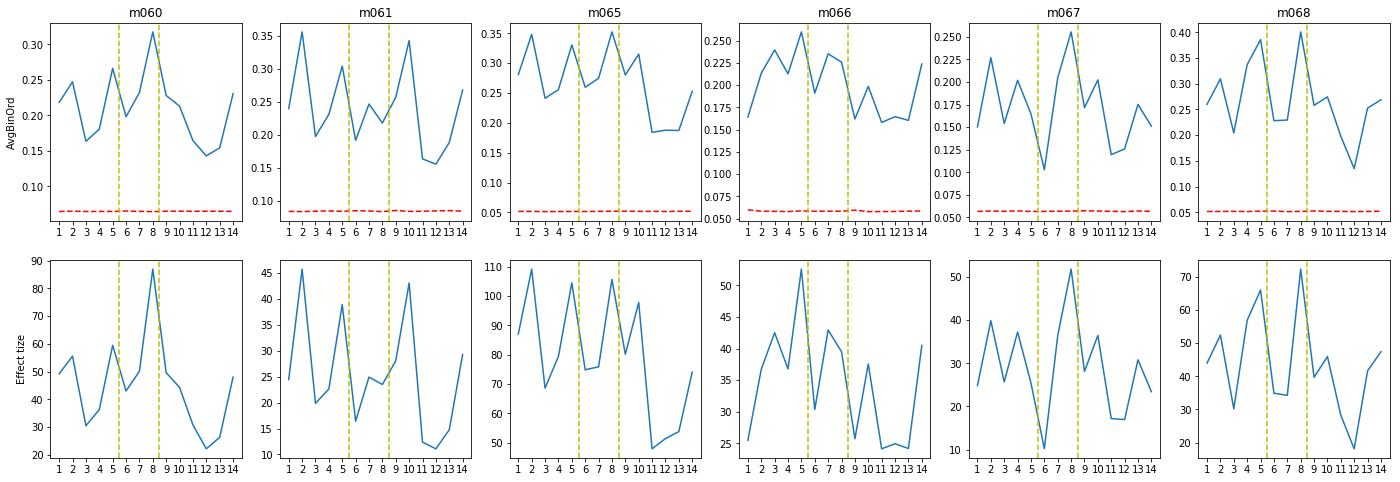

In [19]:
def test_average_orderability(dataDB, queryDict):    
    nMice = len(dataDB.mice)
    
    figTot, axTot = plt.subplots(figsize=(4,4))
    axTot.set_ylabel("AvgBinOrd")
    
    fig, ax = plt.subplots(nrows=2, ncols=nMice, figsize=(nMice*4, 2*4))
    ax[0, 0].set_ylabel("AvgBinOrd")
    ax[1, 0].set_ylabel("Effect tize")
    
    nInterv = 14
    intervIdxs = np.arange(1, nInterv + 1)
    
    fTrueAllLst = []
    fRandAllLst = []
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Doing mouse", mousename)
        queryDictThis = {**queryDict, **{'mousename' : mousename}}
        
        fTrueLst = []
        fRandLst = []
        effSizeLst = []
        
        for interval in range(nInterv):
        
            # Calculate orderability and temporal means
            settings = {"dropShortTrialsTHR" : 4}
            dataTempMu = metric_by_selector(dataDB, queryDictThis, "ord_mean", "rp", {"interval" : interval}, settings)

            func_ABO = avg_bivariate_binary_orderability_from_temporal_mean

            permSettings = {"haveEffectSize":True, "haveMeans":True}
            pValL, pValR, effSize, fTrue, fRand = perm_test(func_ABO, dataTempMu, permAxis=1, iterAxis=0, nSample=200, settings=permSettings)
            
            fTrueLst += [fTrue]
            fRandLst += [fRand]
            effSizeLst += [effSize]
            
        fTrueAllLst += [fTrueLst]
        fRandAllLst += [fRandLst]
            
        ax[0, iMouse].set_title(mousename)
        ax[0, iMouse].plot(intervIdxs, fTrueLst)
        ax[0, iMouse].plot(intervIdxs, fRandLst, '--r')
        ax[1, iMouse].plot(intervIdxs, effSizeLst)
        
        ax[0, iMouse].axvline(x=5.5, linestyle='--', color='y')
        ax[0, iMouse].axvline(x=8.5, linestyle='--', color='y')
        ax[1, iMouse].axvline(x=5.5, linestyle='--', color='y')
        ax[1, iMouse].axvline(x=8.5, linestyle='--', color='y')
        
        ax[0, iMouse].set_xticks(intervIdxs)
        ax[1, iMouse].set_xticks(intervIdxs)
        
    
    axTot.set_title('Allmice')
    axTot.plot(intervIdxs, np.mean(fTrueAllLst, axis=0))
    axTot.plot(intervIdxs, np.mean(fRandAllLst, axis=0), '--r')
    axTot.axvline(x=5.5, linestyle='--', color='y')
    axTot.axvline(x=8.5, linestyle='--', color='y')
    axTot.set_xticks(intervIdxs)
    
    plt.figure(figTot.number)
    plt.savefig("orderability_test_by_intervals_allmice.pdf")
    
    plt.figure(fig.number)
    plt.savefig("orderability_test_by_intervals.pdf")
    plt.show()
                
queryDict = {'datatype' : 'deconv'}
test_average_orderability(dataDB, queryDict)